In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# load calorie requirements by age
calorie_df = pd.read_csv('../data/calorie_requirements.csv')
calorie_df = calorie_df[['age_low','age_high','male_moderate_activity','female_moderate_activity']]
calorie_df.columns = ['age_low','age_high','male','female']

<AxesSubplot:xlabel='age', ylabel='daily calorie need'>

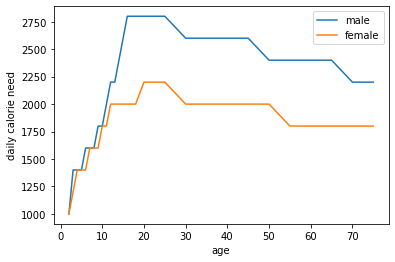

In [10]:
calorie_df.iloc[:-1].plot.line(
    x='age_high',
    y=['male','female'],
    ylabel='daily calorie need', xlabel='age'
)

In [ ]:
# new col with bracket
# calorie_df.loc[:,'bracket'] = [find_bracket(age_high) for age_high in calorie_df.age_high]

In [11]:
# compute minimum daily calories for young men with moderate activity level
# factor .75 because an estimated 25% of caloric needs can be covered by fat reserves (for a short amount of time)
min_cal = calorie_df.values.max() * .75

In [233]:
# set water need reference values (for young men)
# 3l because no water will be consumed by eating stored dried fruit
drinkable_water_reference = 3

In [14]:
# load age structure per stadtbezirk
path = '../data/Stadtbezirke/Stadtbezirk{}.xlsx'
bezirk_ids = [('0' + str(id))[-2:] for id in range(1,11)]

In [16]:
# load relevant population data
# will be needed to estimate different needs

# load a sample to get the index
bezirk_df = pd.read_excel(path.format(bezirk_ids[4]))[26:37]
bezirke_idx = bezirk_df['Unnamed: 0']

# func to read all files
def read_bezirk(id):
    bezirk_path = path.format(id)
    return pd.read_excel(bezirk_path)[26:37]['Unnamed: 1']
    
# get a list with relevant dfs
bezirk_list = [
    read_bezirk(id)
    for id
    in bezirk_ids
]


In [36]:
from numpy import NaN
# combine singular dfs in full df for all districts
bezirke_struktur = (
    pd.concat(bezirk_list,axis=1)
    .set_index(bezirke_idx)
    .drop(NaN)
)
# rename cols to official district names
bezirke_struktur.columns = [
    'bezirk_' + id
    for id
    in bezirk_ids
]

# drop unnecessary col
bezirke_struktur.drop(bezirke_struktur.index[2],axis=0,inplace=True)

In [43]:
# func to separate into biological sexes (estimation)
def separate_sex(n_male, n_female, age_series, bezirk_id):
    n_male = int(n_male.replace(' ',''))
    n_female = int(n_female.replace(' ',''))
    male_series = age_series.copy() * n_male /(n_male+n_female)
    male_series.name = 'bezirk_' + bezirk_id + '_male'
    female_series = age_series.copy() * n_female /(n_male+n_female)
    female_series.name = 'bezirk_' + bezirk_id + '_female'
    return pd.DataFrame([male_series.astype('int'), female_series.astype('int')])


In [26]:
# func to estimate age and sex structure in each district
def separator(n):
    series = bezirke_struktur.iloc[:,n]
    return separate_sex(series['männlich'],series['weiblich'],series.iloc[2:],bezirk_ids[n])

In [47]:
([
    separator(n)
    for n 
    in range(0,10)
])

[Unnamed: 0        unter 6 Jahre  6 bis unter 18 Jahre  18 bis unter 30 Jahre  \
 bezirk_01_male             2216                  2945                   7176   
 bezirk_01_female           2269                  3016                   7351   
 
 Unnamed: 0        30 bis unter 50 Jahre  50 bis unter 65 Jahre  \
 bezirk_01_male                    15220                   7904   
 bezirk_01_female                  15590                   8096   
 
 Unnamed: 0        65 bis unter 80 Jahre  80 Jahre und älter  
 bezirk_01_male                     4837                2151  
 bezirk_01_female                   4955                2203  ,
 Unnamed: 0        unter 6 Jahre  6 bis unter 18 Jahre  18 bis unter 30 Jahre  \
 bezirk_02_male             1887                  2770                   4739   
 bezirk_02_female           2019                  2964                   5071   
 
 Unnamed: 0        30 bis unter 50 Jahre  50 bis unter 65 Jahre  \
 bezirk_02_male                    10589          

In [48]:
# estimate the age and sex structure per district
separated_df = pd.concat([
    separator(n)
    for n 
    in range(0,10)
])
separated_df.columns = ['upto_5','upto_17','upto_29','upto_49','upto_64','upto_79','upto_1000']

In [33]:
from bisect import bisect

In [30]:
# reload cal df 
calorie_df = pd.read_csv('../data/calorie_requirements.csv')
calorie_df = calorie_df[['age_low','age_high','male_moderate_activity','female_moderate_activity']]

In [31]:
# important func to get calorie need means (-25%)
# first age limit should be zero
# returns mean cal need for people includeing the age limit
def get_cal_means(*age_limits):
    means = []
    for i in range(len(age_limits)-1):
        first_row = bisect(calorie_df.age_high,age_limits[i])
        last_row = bisect(calorie_df.age_high,age_limits[i+1])
        means.append(round(calorie_df.iloc[first_row:last_row][['male_moderate_activity','female_moderate_activity']].mean()*.75))
        
    return means

In [52]:
# choose the age limits, compute the mean cal need per age bracket
age_limits = [0,5,17,29,49,64,79,1000]
cal_brackets = pd.DataFrame(get_cal_means(*age_limits))

In [37]:
bezirke_struktur

,bezirk_01,bezirk_02,bezirk_03,bezirk_04,bezirk_05,bezirk_06,bezirk_07,bezirk_08,bezirk_09,bezirk_10
Unnamed: 0,,,,,,,,,,
weiblich,43 483,33 175,61 585,23 508,17 813,33 966,24 610,31 054,48 352,12 884
männlich,42 453,31 008,59 409,21 531,16 721,32 644,22 462,29 714,46 007,11 901
unter 6 Jahre,4486,3907,6266,2861,1764,4147,2574,3500,5649,1613
6 bis unter 18 Jahre,5962,5735,9125,4728,4905,7934,5203,6673,11119,3365
18 bis unter 30 Jahre,14528,9811,23912,4507,3536,8999,5304,8125,13040,3159
30 bis unter 50 Jahre,30811,21920,40962,14033,8366,18659,12213,16167,24742,5722
50 bis unter 65 Jahre,16001,12048,22437,9324,8203,14079,11157,13512,20776,5555
65 bis unter 80 Jahre,9793,7259,12438,6166,4989,8675,7103,8536,12500,3340
80 Jahre und älter,4355,3503,5854,3420,2771,4117,3518,4255,6533,2031


In [39]:
# compute ratio of people in vulnerable age per district
# only use the age structure
bezirke_help_df = bezirke_struktur.copy()[2:]

In [40]:
# func to compute pctage of people in vulnerable age
def agg_vulnerable_age_ratio(series):
    return (
        str(round(
            100* (1-(
                series.iloc[2:5].sum()/series.sum()
                )),1)) + ' %')
# use the func to get percentage for districts
vulnerable_ratio = bezirke_help_df.agg(agg_vulnerable_age_ratio)

In [59]:
# func to get sum of series
def agg_people_count(series):
    return series.sum()

In [54]:
# set new values for age limits (required by structure of raw data)
age_limits = [0,5,17,29,49,64,79,100]

# func to estimate total needs in a district by sex
def dist_need(male_series,female_series):
    return round(sum([
        need * people / 1000
        for need, people
        in zip(
            female_series,
            cal_brackets.iloc[:,1]
        )
    ] + [
        need * people / 1000
        for need, people
        in zip(
            male_series,
            cal_brackets.iloc[:,0]
        )
    ]))

In [56]:
separated_df=separated_df.swapaxes('index','columns')
# func to get series from separated_df
def series_for_id(id):
    female_series = separated_df['bezirk_'+id+'_female']
    male_series = separated_df['bezirk_'+id+'_male']
    return male_series, female_series

In [60]:
# instantiate need df with cal needs
need_in_dists_df = pd.DataFrame([
    dist_need(series_for_id(id)[0],series_for_id(id)[1])
    for id
    in bezirk_ids
])
# rename cols/index 
need_in_dists_df.index = ['Bezirk_'+id for id in bezirk_ids]
need_in_dists_df.columns = ['daily_need:1000kcal']
# estimate need for drinking water based on calorie needs
need_in_dists_df.loc[:,'daily_need_drinkable_water:m³'] = [round(kcal/2100,2) for kcal in need_in_dists_df.iloc[:,0]]

# reindex vulnerable ratios
vulnerable_ratio.index = need_in_dists_df.index

# get pop in each dist, reindex
people_count = bezirke_help_df.agg(agg_people_count)
people_count.index = need_in_dists_df.index

# add context to need df
need_in_dists_df.loc[:,'in vulnerable age'] = vulnerable_ratio
need_in_dists_df.loc[:,'Einwohner'] = people_count

# load district area data
areas = pd.read_csv('../data/distric_area.csv',delimiter=';')
areas.columns=['bezirk','area']
areas = areas.area.str.replace(',','.').astype(float)

# compute pop density per dist
need_in_dists_df.loc[:,'dichte'] = [
    round(einwohner/flaeche)
    for einwohner, flaeche
    in zip(need_in_dists_df.Einwohner,areas)
]

In [107]:
need_in_dists_df

,daily_need:1000kcal,daily_need_drinkable_water:m³,in vulnerable age,Einwohner,dichte,household_size_mean,year
Bezirk_01,139966,66.65,28.6 %,85936,7605,1.61,2020
Bezirk_02,103333,49.21,31.8 %,64183,8877,1.76,2020
Bezirk_03,197557,94.07,27.8 %,120994,4883,1.66,2020
Bezirk_04,71330,33.97,38.1 %,45039,3552,1.91,2020
Bezirk_05,54575,25.99,41.8 %,34534,678,2.17,2020
Bezirk_06,106179,50.56,37.3 %,66610,3386,2.02,2020
Bezirk_07,74568,35.51,39.1 %,47072,1697,2.01,2020
Bezirk_08,96868,46.13,37.8 %,60768,2892,2.00,2020
Bezirk_09,150265,71.55,37.9 %,94359,2575,2.02,2020
Bezirk_10,39060,18.60,41.8 %,24785,4668,2.22,2020


In [63]:
# get mean household size values and add to need df
# load data, filter relevant
households_df = pd.read_csv('../data/household_size.csv',delimiter=';')
households_df = households_df.iloc[:,[0,3,4,5]]
# rename cols for better workflow
households_df.columns = ['bezirk','single_hh','couple_hh','multi_hh']
# clean data
households_df.single_hh = households_df.single_hh.str.replace('x','0').astype(int)
households_df.couple_hh = households_df.couple_hh.str.replace('x','0').astype(int)
households_df.multi_hh = households_df.multi_hh.str.replace('x','0').astype(int)
# compute sums of household size categories, use those to get mean hh size
households_df = households_df.groupby(['bezirk']).sum()
households_df.loc[:,'hh_mean'] = (households_df.single_hh + 2*households_df.couple_hh + 4*households_df.multi_hh)/(households_df.single_hh + households_df.couple_hh + households_df.multi_hh)
households_df.hh_mean = [round(size,2) for size in households_df.hh_mean]
# add mean hh size to need df
need_in_dists_df.loc[:,'household_size_mean'] = list(households_df.hh_mean)

In [64]:
# new col: year
need_in_dists_df.loc[:,'year'] = 2020

In [65]:
# read prognosis for population growth in DD
einwohnerzahlen = (
    pd.read_csv('../data/einwohner_prognose.csv',delimiter=';')
    .iloc[:15,1:4]
)
# set an index with years
einwohnerzahlen.index=(range(2021,2036))
# change dtypes to integer 
for col in einwohnerzahlen.columns:
    einwohnerzahlen[col] = einwohnerzahlen[col].str.replace(' ','').astype(int)




In [66]:
from numpy import std

In [126]:
# compute mean 
einwohnerzahlen.loc[:,'mean'] = [
    (var1+var2+var3)/3
    for var1, var2, var3
    in zip(
        einwohnerzahlen['Variante 1'],
        einwohnerzahlen['Variante 2'],
        einwohnerzahlen['Variante 3']
    )
]
# compute std for the predicted pop numbers
einwohnerzahlen.loc[:,'std'] = [
    std([var1,var2,var3])
    for var1, var2, var3
    in zip(
        einwohnerzahlen['Variante 1'],
        einwohnerzahlen['Variante 2'],
        einwohnerzahlen['Variante 3']
    )
]

In [69]:
# save need df under new name (better workflow)
data_2020 = need_in_dists_df
# get pop count today
pop_2020 = data_2020.Einwohner.sum()

In [71]:
# list of cols to recompute for changing pop numbers
recomp_cols = ['daily_need:1000kcal','daily_need_drinkable_water:m³','Einwohner','dichte']

In [112]:
# compute data for each year based on pop count prediction with highest probability

year_df_list = [data_2020.copy()]
for year in einwohnerzahlen.index:
    df = data_2020.copy()
    df.year = year
    for col in recomp_cols:
        df[col] = df[col] * einwohnerzahlen['Variante 2'][year]/644280
        
    year_df_list.append(df)
all_years = pd.concat(year_df_list)

In [114]:
# round the values
all_years['daily_need:1000kcal'] = all_years['daily_need:1000kcal'].astype(int)
all_years.Einwohner = all_years.Einwohner.astype(int)
all_years.dichte = all_years.dichte.astype(int)

all_years['daily_need_drinkable_water:m³'] =round(all_years['daily_need_drinkable_water:m³'],2)

In [115]:
# rename index, reset index, sort by bezirk and year, reset index again
all_years.index.name = 'bezirk'
all_years.reset_index(inplace=True)

all_years.sort_values(['bezirk','year']).reset_index(drop=True,inplace=True)


In [117]:
# copy all years for safety, not needed in production version
all_years_help = all_years.copy()
# rename cols, change dtype of ratio to float (as requested by front end)
all_years_help.columns=['bezirk','food','water','ratio_vulnerable_age','population','pop_density','mean_household_size','year']
all_years_help.ratio_vulnerable_age = round(all_years_help.ratio_vulnerable_age.str.replace(' %','').astype('float'),1)

In [122]:
# create a series of dicts
dict_series = pd.Series([
    all_years_help.loc[all_years_help.bezirk == 'Bezirk_'+id].set_index('year').drop('bezirk',axis=1).to_dict('index')
    for id in bezirk_ids
])
dict_series.index = all_years_help.bezirk.unique()

# turn series into dict itself, this is requested by frontend
    
data_dict = dict_series.to_dict()

# save dict as json 
import json
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)


with open('../data/bezirke.json','w') as f:
    json.dump(data_dict,f,cls=NpEncoder)

In [125]:
einwohnerzahlen

,Variante 1,Variante 2,Variante 3
2021,649600,650300,651100
2022,653300,654700,656300
2023,657000,659100,661100
2024,660700,663500,666800
2025,663400,666900,671000
2026,666200,670300,675300
2027,669200,674000,679800
2028,672200,677700,684300
2029,675200,681300,688800
2030,678200,685000,693200


In [128]:
# compute relative std in pop number predictions
einwohnerzahlen.loc[:,'rel_std'] = [
    std/var2
    for std, var2
    in zip(einwohnerzahlen['std'],einwohnerzahlen['Variante 2'])
]

In [ ]:
# join rel std to all year df
all_years_help =all_years_help.join(einwohnerzahlen.rel_std, on='year').fillna(0)

In [141]:
all_years_help

,bezirk,food,water,ratio_vulnerable_age,population,pop_density,mean_household_size,year,rel_std
0,Bezirk_01,139966,66.65,28.6,85936,7605,1.61,2020,0.000000
1,Bezirk_02,103333,49.21,31.8,64183,8877,1.76,2020,0.000000
2,Bezirk_03,197557,94.07,27.8,120994,4883,1.66,2020,0.000000
3,Bezirk_04,71330,33.97,38.1,45039,3552,1.91,2020,0.000000
4,Bezirk_05,54575,25.99,41.8,34534,678,2.17,2020,0.000000
...,...,...,...,...,...,...,...,...,...
155,Bezirk_06,115773,55.13,37.3,72629,3691,2.02,2035,0.012978
156,Bezirk_07,81306,38.72,39.1,51325,1850,2.01,2035,0.012978
157,Bezirk_08,105621,50.30,37.8,66259,3153,2.00,2035,0.012978
158,Bezirk_09,163843,78.02,37.9,102885,2807,2.02,2035,0.012978


In [ ]:
all_years_help.set_index('bezirk',inplace=True)

<AxesSubplot:xlabel='bezirk', ylabel='daily need of drinking water by district in 2020'>

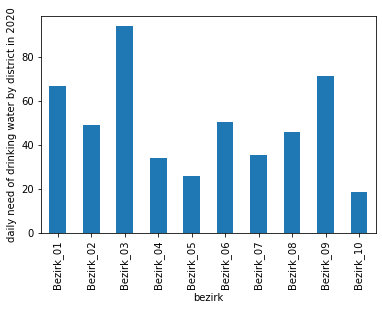

In [149]:

all_years_help.loc[all_years_help.year==2020,'water'].plot(kind='bar',ylabel='daily need of drinking water by district in 2020')

# stop here, rest is not fully functional
<br>Thank you for your attention :)

In [132]:
# plotting func with confidence interval
import plotly.graph_objs as go



In [150]:
# set col to plot
col_name = 'water'

<AxesSubplot:xlabel='bezirk'>

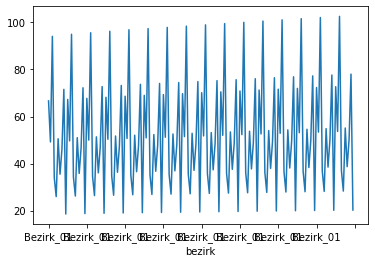

In [153]:

x = list(range(2020,2036))
y = all_years_help[col_name]
y_upper = [
    val*std + val
    for val, std
    in zip(y, einwohnerzahlen['std'])
]

y_lower = [
    -val*std + val
    for val, std
    in zip(y, einwohnerzahlen['std'])
]


fig = go.Figure([
    go.Scatter(
        x=x,
        y=y,
        line=dict(color='rgb(0,100,80)'),
        mode='lines'
    ),
    go.Scatter(
        x=x+x[::-1], # x, then x reversed
        y=y_upper+y_lower[::-1], # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    )
])

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [134]:
bez1 = all_years_help.loc[all_years_help.bezirk == all_years_help.bezirk.unique()[0]]

In [135]:
bez1

,bezirk,food,water,ratio_vulnerable_age,population,pop_density,mean_household_size,year,rel_std
0,Bezirk_01,139966,66.65,28.6,85936,7605,1.61,2020,0.000000
10,Bezirk_01,141273,67.27,28.6,86738,7676,1.61,2021,0.000942
20,Bezirk_01,142229,67.73,28.6,87325,7727,1.61,2022,0.001872
30,Bezirk_01,143185,68.18,28.6,87912,7779,1.61,2023,0.002540
40,Bezirk_01,144141,68.64,28.6,88499,7831,1.61,2024,0.003758
50,Bezirk_01,144880,68.99,28.6,88953,7872,1.61,2025,0.004657
60,Bezirk_01,145618,69.34,28.6,89406,7912,1.61,2026,0.005551
70,Bezirk_01,146422,69.72,28.6,89900,7955,1.61,2027,0.006430
80,Bezirk_01,147226,70.11,28.6,90393,7999,1.61,2028,0.007299
90,Bezirk_01,148008,70.48,28.6,90873,8041,1.61,2029,0.008164


In [411]:
all_years

,bezirk,year,daily_need:1000kcal,daily_need_drinkable_water:m³,mean age,in vulnerable age,Einwohner,dichte,household_size_mean
0,Bezirk_01,2020,139966,66.65,42.0,28.6 %,85936,7605,1.61
1,Bezirk_02,2020,103333,49.21,41.5,31.8 %,64183,8877,1.76
2,Bezirk_03,2020,197557,94.07,40.9,27.8 %,120994,4883,1.66
3,Bezirk_04,2020,71330,33.97,44.0,38.1 %,45039,3552,1.91
4,Bezirk_05,2020,54575,25.99,44.4,41.8 %,34534,678,2.17
...,...,...,...,...,...,...,...,...,...
5,Bezirk_06,2035,115773,55.13,42.3,37.3 %,72629,3691,2.02
6,Bezirk_07,2035,81306,38.72,44.9,39.1 %,51325,1850,2.01
7,Bezirk_08,2035,105621,50.30,43.7,37.8 %,66259,3153,2.00
8,Bezirk_09,2035,163843,78.02,43.0,37.9 %,102885,2807,2.02


In [389]:
data_2021

,bezirk,year,daily_need:1000kcal,daily_need_drinkable_water:m³,mean age,in vulnerable age,Einwohner,dichte,household_size_mean
0,Bezirk_01,2020,141273.809213,67.272762,42.0,28.6 %,86738.965667,7676.059322,1.61
1,Bezirk_02,2020,104298.519122,49.669807,41.5,31.8 %,64782.710778,8959.944589,1.76
2,Bezirk_03,2020,199402.925902,94.948968,40.9,27.8 %,122124.539331,4928.625598,1.66
3,Bezirk_04,2020,71996.490656,34.287408,44.0,38.1 %,45459.833768,3585.189048,1.91
4,Bezirk_05,2020,55084.935897,26.232844,44.4,41.8 %,34856.677532,684.335072,2.17
5,Bezirk_06,2020,107171.111473,51.032421,42.3,37.3 %,67232.388092,3417.637983,2.02
6,Bezirk_07,2020,75264.745763,35.841797,44.9,39.1 %,47511.829639,1712.856367,2.01
7,Bezirk_08,2020,97773.111691,46.561028,43.7,37.8 %,61335.801825,2919.022164,2.00
8,Bezirk_09,2020,151669.040635,72.218546,43.0,37.9 %,95240.668188,2599.060191,2.02
9,Bezirk_10,2020,39424.967405,18.773794,43.2,41.8 %,25016.585180,4711.616688,2.22


In [385]:
year_list = range(2021,2036)

In [386]:
year_list

range(2021, 2036)

In [327]:
import json

In [354]:
with open('../data/bezirke.json','w') as f:
    json.dump(jsonfile,f,cls=NpEncoder)

In [ ]:
to_convert.loc[:,'year'] = 

In [281]:
need_in_dists_df.to_csv('../data/district_stats_2020.csv')

In [359]:
round(sum([
    need * people / 1000
    for need, people
    in zip(
        separated_df.iloc[:,1],
        cal_brackets.iloc[:,1]
    )
] + [
    need * people / 1000
    for need, people
    in zip(
        separated_df.iloc[:,0],
        cal_brackets.iloc[:,0]
    )
]))

58218

In [278]:
separated_df

,upto_5,upto_17,upto_29,upto_49,upto_64,upto_79,upto_1000
bezirk_01_male,2216,2945,7176,15220,7904,4837,2151
bezirk_01_female,2269,3016,7351,15590,8096,4955,2203
bezirk_02_male,1887,2770,4739,10589,5820,3506,1692
bezirk_02_female,2019,2964,5071,11330,6227,3752,1810
bezirk_03_male,3076,4480,11740,20112,11016,6107,2874
bezirk_03_female,3189,4644,12171,20849,11420,6330,2979
bezirk_04_male,1367,2260,2154,6708,4457,2947,1634
bezirk_04_female,1493,2467,2352,7324,4866,3218,1785
bezirk_05_male,854,2374,1712,4050,3971,2415,1341
bezirk_05_female,909,2530,1823,4315,4231,2573,1429


In [7]:
# load age bracket data
age_bracket_numbers = pd.read_csv('../data/altersklassen.csv',delimiter=';')
# only keep percentage cols
cols = [col for col in age_bracket_numbers.columns if ('Prozent' in col)] + ['Jahr']
age_bracket_numbers = age_bracket_numbers[cols]

In [14]:
age_bracket_numbers

,unter 18 Jahre in Prozent,18 bis unter 25 Jahre in Prozent,25 bis unter 50 Jahre in Prozent,50 bis unter 65 Jahre in Prozent,65 Jahre und aelter in Prozent,Personen im erwerbsfaehigen Alter in Prozent,Jahr
0,"15,1","7,2","39,1","19,2","19,3","67,9",2014
1,"15,3","7,3","39,0","19,3","19,1","67,9",2015
2,"15,5","7,3","38,6","19,6","19,0","67,9",2016
3,"15,6","7,2","38,5","19,9","18,9","67,9",2017
4,"15,7","7,1","38,2","20,2","18,8","67,8",2018
5,"15,8","7,0","38,1","20,4","18,7","67,8",2019


In [13]:
age_bracket_numbers.iloc[:,0]

0    15,1
1    15,3
2    15,5
3    15,6
4    15,7
5    15,8
Name: unter 18 Jahre in Prozent, dtype: object

In [12]:
model = np.polyfit(age_bracket_numbers.iloc[:,0],age_bracket_numbers.Jahr,1)

TypeError: can only concatenate str (not "float") to str